# Мастерская 2. Маркетинг

Цель:
<br/>Предсказать вероятность покупки пользователями в интернет-магазине в течение 90 дней
<br/>
<br/>Задачи:
<br/>- Изучить данные
<br/>- Разработать полезные признаки
<br/>- Создать модель для классификации пользователей
<br/>- Улучшить модель и максимизировать метрику roc_auc
<br/>- Выполнить тестирование
<br/>
<br/>Исходные данные:
<br/>apparel-purchases.csv - история покупок
<br/>apparel-messages.csv - история рекламных рассылок
<br/>apparel-target_binary.csv - информация о том, совершит ли клиент покупку в течение следующих 90 дней

    

In [1]:
!pip install phik -q
!pip install shap -q
!pip install -U scikit-learn
!pip install optuna-integration -q 
!pip install lightgbm
!pip install catboost
!pip install xgboost

In [2]:
import os
import time
import re

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import ast
import phik
from phik.report import plot_correlation_matrix
import shap
from sklearn.preprocessing import (
    OneHotEncoder, 
    OrdinalEncoder, 
    StandardScaler, 
    MinMaxScaler, 
    RobustScaler, 
    FunctionTransformer)
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.metrics import root_mean_squared_error, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

In [3]:
RANDOM_STATE = 1
TEST_SIZE = 0.25

## Загрузка данных

In [4]:
df_purch = pd.read_csv("apparel-purchases.csv", parse_dates=True)

In [5]:
df_mess = pd.read_csv("apparel-messages.csv", parse_dates=True)

In [6]:
df_tar = pd.read_csv("apparel-target_binary.csv")

In [7]:
df_purch.head(10)

,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843
5,1515915625471640575,1,3499.0,"['2', '18', '258', '441']",2022-05-16,1515915625471640575-4301-627b661b67ac3
6,1515915625490211585,1,1699.0,"['2', '18', '341', '1311']",2022-05-16,1515915625490211585-4301-627b661843283
7,1515915625490739153,1,1999.0,"['2', '18', '123', '451']",2022-05-16,1515915625490739153-4172-626b943cc789b
8,1515915625491478747,1,999.0,"['5562', '5631', '5549', '667']",2022-05-16,1515915625491478747-4273-6274ceb769d59
9,1515915625491651493,1,699.0,"['5562', '5630', '5649', '678']",2022-05-16,1515915625491651493-4437-6282242f2a9e2


In [8]:
df_mess.head(10)

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52
5,4439,1515915625594606468,1515915625594606468-4439-6283411f277fc,open,email,2022-05-19,2022-05-19 01:04:11
6,4439,1515915625491810918,1515915625491810918-4439-6283411d9d299,open,email,2022-05-19,2022-05-19 01:19:54
7,4439,1515915625474219766,1515915625474219766-4439-628341212233a,open,email,2022-05-19,2022-05-19 01:23:43
8,4439,1515915625474219766,1515915625474219766-4439-628341212233a,click,email,2022-05-19,2022-05-19 01:24:16
9,4439,1515915625566741491,1515915625566741491-4439-6283412871599,open,email,2022-05-19,2022-05-19 01:31:06


In [9]:
df_tar.head()

,client_id,target
0,1515915625468060902,0
1,1515915625468061003,1
2,1515915625468061099,0
3,1515915625468061100,0
4,1515915625468061170,0


Загружены данные об истории покупателей, истории рекламных рассылок и целевого признака.

## Предобработка данных

In [10]:
def data_info(data, data_name):
    """Выводит информацию о столбцах таблицы для предобработки данных: 
    информация о столбцах таблицы, кол-во незаполненных значений в полях, число дубликатов
    Args:
        data - датасет
        data_name - наименование датасета
    Returns:
        нет возвращаемых данных
    Raises:
        нет обработки ошибок
    """
    print("Информация о столбцах таблицы ", data_name)
    display(data.info())
    print("Количество незаполненных значений в полях:")
    print(data.isna().sum())
    dupl = data.duplicated().sum()
    print("Количество дубликатов:", dupl)  

In [11]:
def dupl_processing(data):
    """Удаление дубликатов таблицы с отображением информации о столбцах
    Args:
        data - датасет
    Returns:
        нет возвращаемых данных
    Raises:
        нет обработки ошибок
    """
    data = data.drop_duplicates()
    print("Выполнено удаление дубликатов")     
    print("Информация о столбцах таблицы ")
    display(data.info())
    return data

In [12]:
def col_info(data, list_cols):
    """Информация по количеству уникальных значений в столбцах таблицы
    Args:
        data - датасет
        list_cols - список столбцов для вывода уникальных значений
    Returns:
        нет возвращаемых данных
    Raises:
        нет обработки ошибок
    """
    for col in list_cols:
        print('----------------------')
        print(data[col].value_counts().sort_index())   
        

In [13]:
def to_lower_case(data, list_cols):
    """приведение значений в столбцах таблицы к нижнему регистру
    Args:
        data - датасет
        list_cols - список столбцов со строковыми значениями
    Returns:
        нет возвращаемых данных
    Raises:
        нет обработки ошибок
    """    
    for col in list_cols:
        data[col] = data[col].apply(str.lower)
    return data

In [14]:
data_info(df_purch, "История покупок")

Информация о столбцах таблицы  История покупок
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   client_id     202208 non-null  int64  
 1   quantity      202208 non-null  int64  
 2   price         202208 non-null  float64
 3   category_ids  202208 non-null  object 
 4   date          202208 non-null  object 
 5   message_id    202208 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 9.3+ MB


None

Количество незаполненных значений в полях:
client_id       0
quantity        0
price           0
category_ids    0
date            0
message_id      0
dtype: int64
Количество дубликатов: 73020


In [15]:
df_purch['date'] = pd.to_datetime(df_purch['date'])

In [16]:
df_purch = dupl_processing(df_purch)

Выполнено удаление дубликатов
Информация о столбцах таблицы 
<class 'pandas.core.frame.DataFrame'>
Int64Index: 129188 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   client_id     129188 non-null  int64         
 1   quantity      129188 non-null  int64         
 2   price         129188 non-null  float64       
 3   category_ids  129188 non-null  object        
 4   date          129188 non-null  datetime64[ns]
 5   message_id    129188 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 6.9+ MB


None

In [17]:
col_info(df_purch, ["quantity", "category_ids", "date"])

----------------------
1     128352
2        714
3         86
4         12
5          3
6          4
7          1
8          1
9          1
10         3
13         1
15         3
18         1
20         2
25         2
30         2
Name: quantity, dtype: int64
----------------------
['1', '22', '50', '685']               2
['1', '8', '280', '710']               1
['2', '17', '107', '453']             58
['2', '17', '137', '469']            193
['2', '17', '171', '475']            104
                                    ... 
['6060', '6059', '6071', '6292']      12
['6060', '6059', '6072', '1853']      49
['6060', '6059', '6076', '1153']      76
[None]                               622
[]                                  2738
Name: category_ids, Length: 933, dtype: int64
----------------------
2022-05-16     34
2022-05-17    405
2022-05-18    230
2022-05-19    140
2022-05-20    699
             ... 
2024-02-12    182
2024-02-13    240
2024-02-14    267
2024-02-15     79
2024-02-16    326

In [18]:
#подсчет числа элементов в списке категорий.
ser_cat = df_purch['category_ids'].str.count(',')
ser_cat.value_counts()
#категорий не более 5, в принципе можно разместить отдельные столбцы под категории

3    124747
0      3360
2       736
4       345
Name: category_ids, dtype: int64

In [19]:
df_purch['category_ids'] = df_purch['category_ids'].apply(ast.literal_eval) 

In [20]:
for pos in range(0,5):
    df_purch['category_' + str(pos)] =\
    df_purch.apply(lambda x: x['category_ids'][pos] if (~(x['category_ids'] is np.nan) & (len(x['category_ids']) > pos)) else 0, axis=1)
    df_purch['category_' + str(pos)] = df_purch['category_' + str(pos)].fillna(0)
    df_purch['category_' + str(pos)] = df_purch['category_' + str(pos)].astype(int)

In [21]:
df_purch.head()

,client_id,quantity,price,category_ids,date,message_id,category_0,category_1,category_2,category_3,category_4
0,1515915625468169594,1,1999.0,"[4, 28, 57, 431]",2022-05-16,1515915625468169594-4301-627b661e9736d,4,28,57,431,0
1,1515915625468169594,1,2499.0,"[4, 28, 57, 431]",2022-05-16,1515915625468169594-4301-627b661e9736d,4,28,57,431,0
2,1515915625471138230,1,6499.0,"[4, 28, 57, 431]",2022-05-16,1515915625471138230-4437-6282242f27843,4,28,57,431,0
3,1515915625471138230,1,4999.0,"[4, 28, 244, 432]",2022-05-16,1515915625471138230-4437-6282242f27843,4,28,244,432,0
4,1515915625471138230,1,4999.0,"[4, 28, 49, 413]",2022-05-16,1515915625471138230-4437-6282242f27843,4,28,49,413,0


In [22]:
col_info(df_purch, ['category_0', 'category_1', 'category_2', 'category_3', 'category_4'])

----------------------
0        3360
1           3
2       17995
3           6
4       73428
5           1
5562    29148
5963      789
6060     4458
Name: category_0, dtype: int64
----------------------
0        3360
8           1
10          1
12          4
14          2
17       1959
18      16036
22          2
27       7223
28      53564
29       3280
30         59
31       5562
44        705
1822     2476
5536     2997
5558      273
5589     4007
5597     1199
5599      201
5630     6543
5631     5494
5632     1207
5633     3626
5634     2767
5683      776
5697       58
5837      559
5959      789
6057      619
6058     3358
6059      481
Name: category_1, dtype: int64
----------------------
0       3360
38      1085
44       272
49      1652
50         2
        ... 
6244      73
6245      79
6265      18
6266      34
6309      14
Name: category_2, Length: 292, dtype: int64
----------------------
0       4096
387      345
413     1299
415     2735
416      226
        ... 
6281   

In [23]:
data_info(df_mess, "История рекламных рассылок")

Информация о столбцах таблицы  История рекламных рассылок
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   bulk_campaign_id  int64 
 1   client_id         int64 
 2   message_id        object
 3   event             object
 4   channel           object
 5   date              object
 6   created_at        object
dtypes: int64(2), object(5)
memory usage: 680.4+ MB


None

Количество незаполненных значений в полях:
bulk_campaign_id    0
client_id           0
message_id          0
event               0
channel             0
date                0
created_at          0
dtype: int64
Количество дубликатов: 48610


In [24]:
col_info(df_mess, ['event', 'channel'])

----------------------
click           496339
close                1
complain           528
hard_bounce      19903
hbq_spam           823
open           3085820
purchase         64679
send           9058196
soft_bounce      10583
subscribe           85
unsubscribe       2841
Name: event, dtype: int64
----------------------
email          5227642
mobile_push    7512156
Name: channel, dtype: int64


In [25]:
df_mess['date'] = pd.to_datetime(df_mess['date'])

In [26]:
df_mess['created_at'] = pd.to_datetime(df_mess['created_at'])

In [27]:
df_mess = dupl_processing(df_mess)

Выполнено удаление дубликатов
Информация о столбцах таблицы 
<class 'pandas.core.frame.DataFrame'>
Int64Index: 12691188 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype         
---  ------            -----         
 0   bulk_campaign_id  int64         
 1   client_id         int64         
 2   message_id        object        
 3   event             object        
 4   channel           object        
 5   date              datetime64[ns]
 6   created_at        datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(3)
memory usage: 774.6+ MB


None

In [28]:
data_info(df_mess, "История рекламных рассылок")

Информация о столбцах таблицы  История рекламных рассылок
<class 'pandas.core.frame.DataFrame'>
Int64Index: 12691188 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype         
---  ------            -----         
 0   bulk_campaign_id  int64         
 1   client_id         int64         
 2   message_id        object        
 3   event             object        
 4   channel           object        
 5   date              datetime64[ns]
 6   created_at        datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(3)
memory usage: 774.6+ MB


None

Количество незаполненных значений в полях:
bulk_campaign_id    0
client_id           0
message_id          0
event               0
channel             0
date                0
created_at          0
dtype: int64
Количество дубликатов: 0


In [29]:
data_info(df_tar, "Таблица с целевым признаком")

Информация о столбцах таблицы  Таблица с целевым признаком
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  49849 non-null  int64
 1   target     49849 non-null  int64
dtypes: int64(2)
memory usage: 779.0 KB


None

Количество незаполненных значений в полях:
client_id    0
target       0
dtype: int64
Количество дубликатов: 0


In [30]:
col_info(df_tar, ['target'])

----------------------
0    48888
1      961
Name: target, dtype: int64


Выполнена предобработка данных:
    - установлены соответствующие типы данных
    - удалены дубликаты
    - значение категорий разбито на 4 отдельных столбца

## Исследовательский анализ данных

### Общий анализ

In [31]:
def numeric_exploration(data, lst_cols):
    """Выполняет построение гистограммы и ящика с усами
    Args:
        data - датасет
        lst_cols - список столбцов с числовыми значениями для обработки
    Returns:
        нет возвращаемых данных
    Raises:
        нет обработки ошибок
    """
    for col in lst_cols:
        print('Статистическая информация по столбцу:', col)
        print(data[col].describe()) 
        
        fig, axs = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw=dict(width_ratios=[4, 3]))
        hpl = sns.histplot(data[col], kde=False, bins=30, ax=axs[0])
        hpl.axes.set_title('Гистограмма по признаку ' + col, fontsize=16)
        hpl.set_xlabel(col, fontsize=14)
        hpl.set_ylabel("Частота", fontsize=14)         
        hpl.grid(True)
        
        bpl = sns.boxplot(data=data, orient='h', x=col, ax=axs[1])
        bpl.axes.set_title('Ящик с усами для признака ' + col, fontsize=16)
        bpl.set_xlabel(col, fontsize=14)
        #bpl.set_ylabel("Значения", fontsize=14)         
        bpl.grid(True)
        fig.tight_layout()
        plt.show()

In [32]:
def category_exploration(data, lst_cols):
    """Выполняет построение диаграммы
    Args:
        data - датасет
        lst_cols - список столбцов с категориальными (непорядковыми) значениями для обработки
    Returns:
        нет возвращаемых данных
    Raises:
        нет обработки ошибок
    """
    if (len(lst_cols) == 1):
        cnt_col = "client_id"
    else: 
        cnt_col = lst_cols[-1]
    for col in lst_cols:
        print(f'Число уникальных значений признака {col} составляет {len(data[col].unique())}')
        a = data.groupby(col).agg({cnt_col:'count'}).reset_index()
        a.columns = [col, 'количество_записей']
        a['Percentage'] = a['количество_записей'] / a['количество_записей'].sum()*100
        a = a.sort_values(['количество_записей'],ascending=False).reset_index(drop=True)        
        a = a.loc[:20,]
        print(a)
        
        fig, ax = plt.subplots(1, figsize=(10, 4))
        sns.barplot(x=col, y='количество_записей', data=a, ax=ax)
        fig.tight_layout()
        plt.show()
        #a.plot(kind='bar', xlabel=col, ylabel='Количество автомобилей', x=col, y='количество_записей',
        #                      title='Количество автомобилей в разрезе признака ' + col, figsize=(8,8))
        cnt_col = col

In [33]:
def discrete_exploration(data, lst_cols):
    """Выполняет построение диаграммы
    Args:
        data - датасет
        lst_cols - список столбцов с категориальными (порядковыми) значениями для обработки
    Returns:
        нет возвращаемых данных
    Raises:
        нет обработки ошибок
    """
    if (len(lst_cols) == 1):
        cnt_col = "client_id"
    else: 
        cnt_col = lst_cols[-1]
    for col in lst_cols:
        a = data.groupby(col).agg({cnt_col:'count'}).reset_index()
        a.columns = [col, 'количество_записей']
        a['Percentage'] = a['количество_записей'] / a['количество_записей'].sum()*100
        a = a.sort_values(['количество_записей'],ascending=False).reset_index(drop=True)        
        a = a.loc[:20,]
        print(a)
        
        fig, ax = plt.subplots(1, figsize=(10, 4))
        sns.countplot(x=col, data=data, ax=ax)
        fig.tight_layout()
        plt.show()
        cnt_col = col

In [34]:
purch_num_cols = ['price']

Статистическая информация по столбцу: price
count    129188.000000
mean       1264.532766
std        1375.016339
min           1.000000
25%         399.000000
50%         999.000000
75%        1750.000000
max       85499.000000
Name: price, dtype: float64


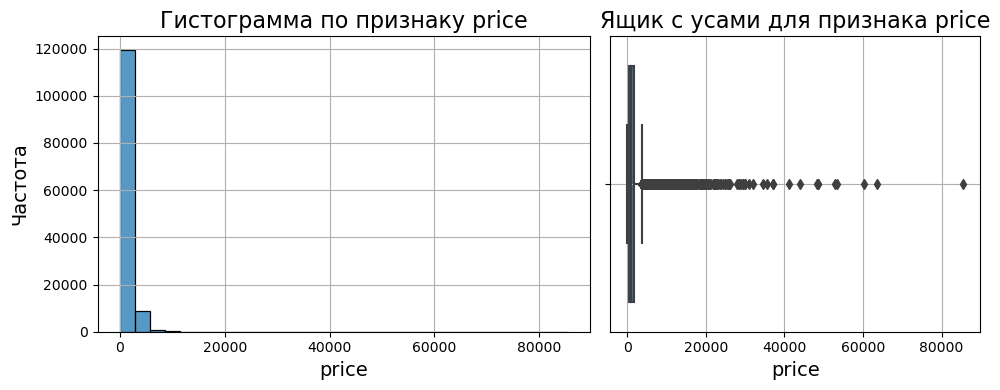

In [35]:
numeric_exploration(df_purch, purch_num_cols)

In [36]:
df_purch[df_purch['price'] > 40000]

,client_id,quantity,price,category_ids,date,message_id,category_0,category_1,category_2,category_3,category_4
6018,1515915625692218402,1,48499.0,"[4, 29, 312, 1576]",2022-06-01,1515915625489907961-4679-62972222453b3,4,29,312,1576,0
138818,1515915625971673322,1,53499.0,"[4, 29, 310, 1577]",2023-06-13,1515915625971673322-13342-648873c693815,4,29,310,1577,0
166576,1515915625776653984,1,63499.0,"[4, 29, 310, 1577]",2023-08-26,1515915625776653984-13719-64e85f9332bc8,4,29,310,1577,0
166578,1515915625776653984,1,60200.0,"[4, 29, 310, 1577]",2023-08-26,1515915625776653984-13719-64e85f9332bc8,4,29,310,1577,0
171434,1515915625959777467,1,43999.0,"[4, 29, 313, 1574]",2023-09-27,1515915625959777467-13868-6513cbb257da6,4,29,313,1574,0
171435,1515915625959777467,1,48499.0,"[4, 29, 313, 1574]",2023-09-27,1515915625959777467-13868-6513cbb257da6,4,29,313,1574,0
171436,1515915625959777467,1,52999.0,"[4, 29, 313, 1574]",2023-09-27,1515915625959777467-13868-6513cbb257da6,4,29,313,1574,0
183759,1515915625660769903,1,41160.0,"[4, 29, 313, 1574]",2023-12-21,1515915625660769903-14320-657c02501844d,4,29,313,1574,0
186736,1515915625553309277,1,85499.0,"[4, 29, 313, 1574]",2023-12-24,1515915625553309277-14352-6585585d7a711,4,29,313,1574,0
198462,1515915625995288129,1,48299.0,"[4, 29, 310, 1577]",2024-01-31,1515915625995288129-14553-65b65deea7556,4,29,310,1577,0


In [37]:
df_purch = df_purch[df_purch['price'] <= 40000]

Статистическая информация по столбцу: price
count    129178.000000
mean       1260.402754
std        1288.033633
min           1.000000
25%         399.000000
50%         999.000000
75%        1750.000000
max       37240.000000
Name: price, dtype: float64


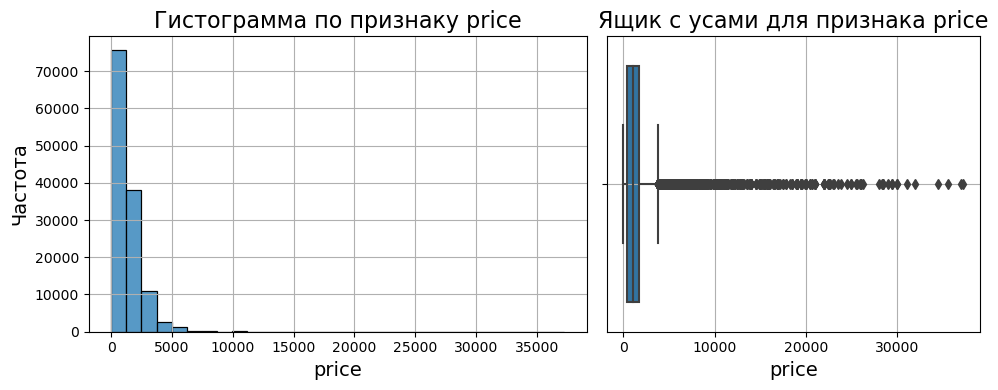

In [38]:
numeric_exploration(df_purch, purch_num_cols)

In [39]:
purch_cat_cols = ['category_0', 'category_1', 'category_2', 'category_3', 'category_4']

Число уникальных значений признака category_0 составляет 9
   category_0  количество_записей  Percentage
0           4               73418   56.834755
1        5562               29148   22.564214
2           2               17995   13.930391
3        6060                4458    3.451052
4           0                3360    2.601062
5        5963                 789    0.610785
6           3                   6    0.004645
7           1                   3    0.002322
8           5                   1    0.000774


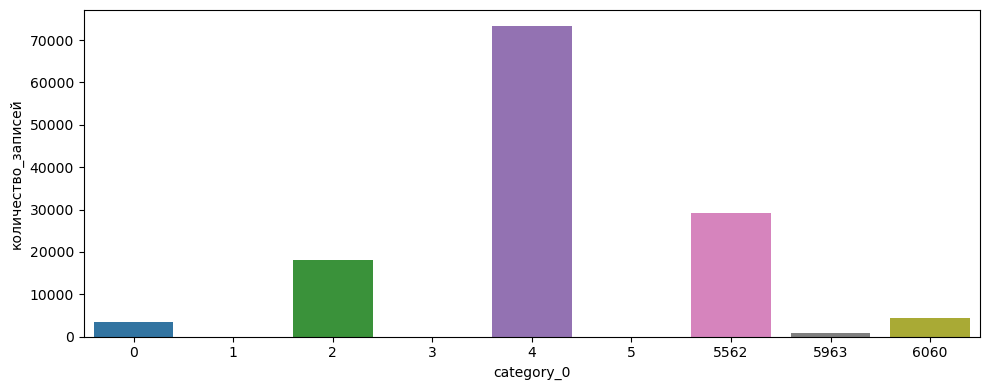

Число уникальных значений признака category_1 составляет 32
    category_1  количество_записей  Percentage
0           28               53564   41.465265
1           18               16036   12.413879
2           27                7223    5.591509
3         5630                6543    5.065104
4           31                5562    4.305687
5         5631                5494    4.253046
6         5589                4007    3.101921
7         5633                3626    2.806980
8            0                3360    2.601062
9         6058                3358    2.599514
10          29                3270    2.531391
11        5536                2997    2.320054
12        5634                2767    2.142006
13        1822                2476    1.916735
14          17                1959    1.516512
15        5632                1207    0.934370
16        5597                1199    0.928177
17        5959                 789    0.610785
18        5683                 776    0.600721


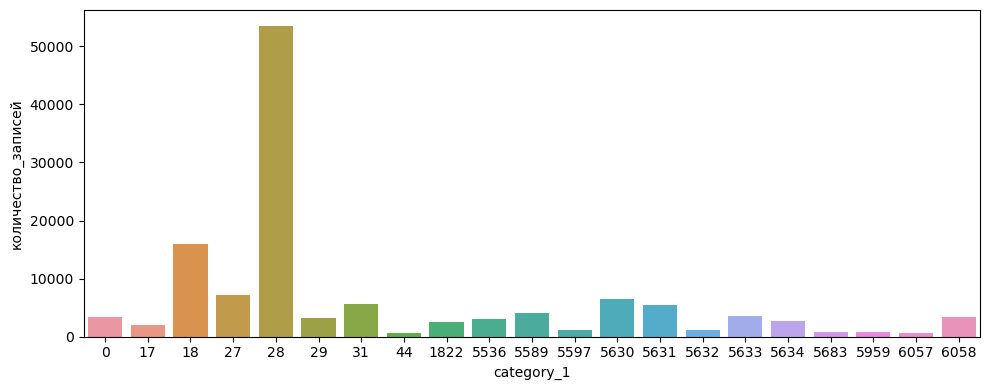

Число уникальных значений признака category_2 составляет 292
    category_2  количество_записей  Percentage
0           57                6191    4.792612
1          275                5776    4.471350
2          260                5570    4.311880
3           62                5326    4.122993
4          244                4835    3.742897
5          258                4665    3.611296
6          290                3541    2.741179
7            0                3360    2.601062
8          213                3185    2.465590
9          124                2812    2.176841
10         249                2517    1.948474
11         324                2485    1.923702
12         212                2181    1.688368
13         343                2108    1.631857
14          61                1940    1.501804
15         326                1867    1.445293
16          58                1798    1.391878
17          49                1652    1.278856
18         146                1580    1.223118

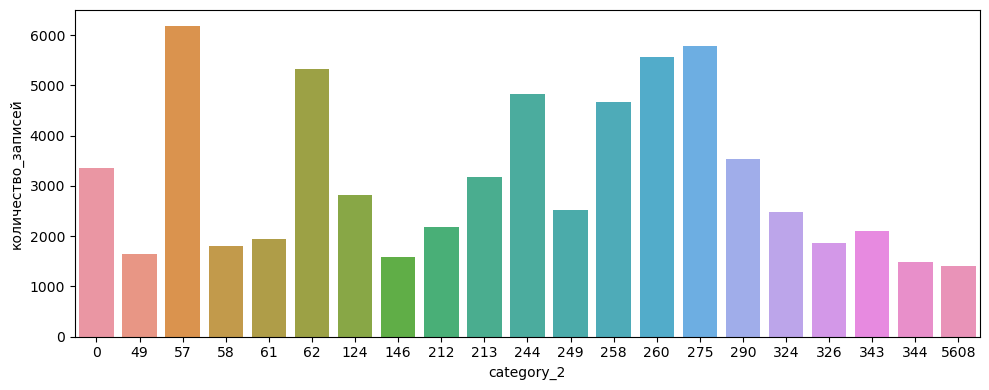

Число уникальных значений признака category_3 составляет 839
    category_3  количество_записей  Percentage
0          431                6191    4.792612
1          432                4835    3.742897
2          420                4421    3.422409
3            0                4096    3.170819
4          421                3309    2.561582
5          441                3175    2.457849
6          657                2841    2.199291
7          415                2735    2.117234
8          656                2485    1.923702
9          673                2322    1.797520
10         422                2080    1.610181
11         436                2075    1.606311
12         425                2037    1.576894
13         505                1867    1.445293
14         445                1487    1.151125
15         616                1399    1.083002
16         548                1378    1.066745
17         661                1316    1.018749
18         413                1299    1.005589

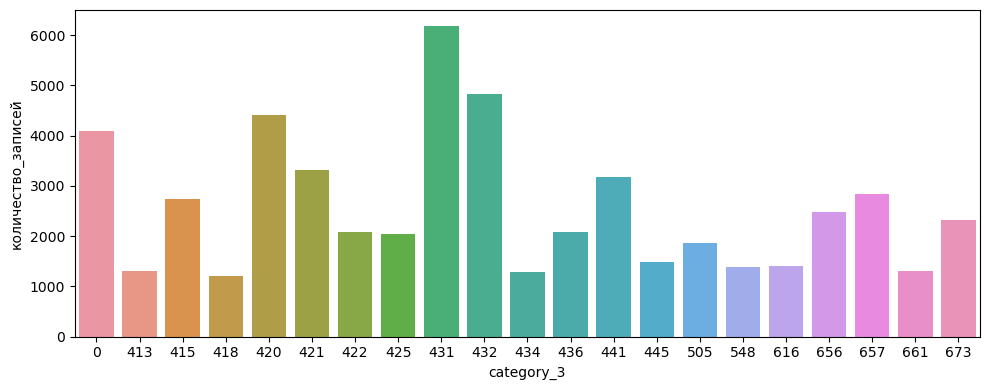

Число уникальных значений признака category_4 составляет 2
   category_4  количество_записей  Percentage
0           0              128833   99.732927
1         467                 345    0.267073


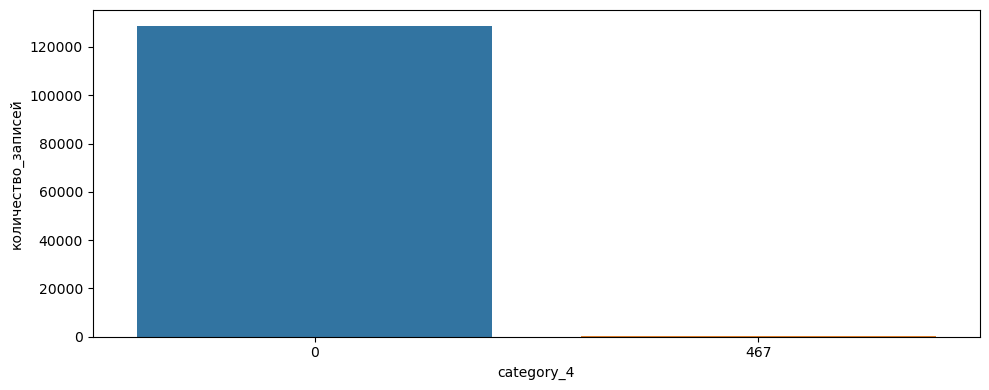

In [40]:
category_exploration(df_purch, purch_cat_cols)

In [41]:
purch_ord_cols = ['quantity']

    quantity  количество_записей  Percentage
0          1              128342   99.352831
1          2                 714    0.552726
2          3                  86    0.066575
3          4                  12    0.009290
4          6                   4    0.003097
5          5                   3    0.002322
6         10                   3    0.002322
7         15                   3    0.002322
8         20                   2    0.001548
9         25                   2    0.001548
10        30                   2    0.001548
11         7                   1    0.000774
12         8                   1    0.000774
13         9                   1    0.000774
14        13                   1    0.000774
15        18                   1    0.000774


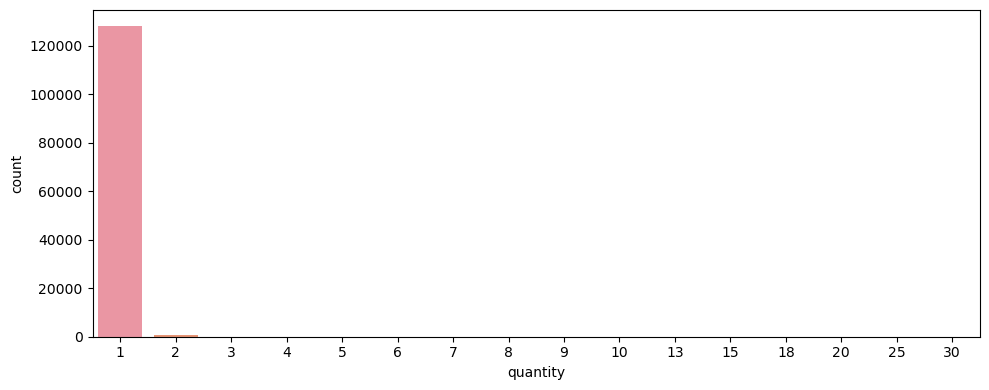

In [42]:
discrete_exploration(df_purch, purch_ord_cols)

In [43]:
df_purch[df_purch['quantity'] > 10]


,client_id,quantity,price,category_ids,date,message_id,category_0,category_1,category_2,category_3,category_4
23702,1515915625540239255,25,2.0,"[5562, 5597, 5691, 889]",2022-07-14,1515915625540239255-5403-62ce6dd7d68a1,5562,5597,5691,889,0
23866,1515915625740853027,20,2.0,"[5562, 5597, 5691, 889]",2022-07-14,1515915625491240655-5403-62ce6db70596e,5562,5597,5691,889,0
26557,1515915625509511395,25,4.0,"[5562, 5597, 5691, 889]",2022-07-27,1515915625509511395-5623-62df9127ce354,5562,5597,5691,889,0
26558,1515915625509511395,13,4.0,"[5562, 5597, 5691, 889]",2022-07-27,1515915625509511395-5623-62df9127ce354,5562,5597,5691,889,0
37005,1515915625548883766,30,2.0,"[5562, 5597, 5691, 889]",2022-09-06,1515915625548883766-6283-6316e248bbbf9,5562,5597,5691,889,0
67945,1515915625892804258,15,3.0,"[4, 1822, 1821, 1613]",2022-12-16,1515915625566723180-8722-639c17d50f223,4,1822,1821,1613,0
85277,1515915625776529170,18,29.0,"[5562, 5589, 5624, 1697]",2023-02-17,1515915625776529170-10179-63edf893515eb,5562,5589,5624,1697,0
126157,1515915625629378288,15,29.0,"[5562, 5589, 5588, 1782]",2023-06-01,1515915625629378288-13004-64785cb507acf,5562,5589,5588,1782,0
158373,1515915625594593699,30,2.0,"[5562, 5597, 5691, 889]",2023-07-12,1515915625468268596-13482-64ae724c9316b,5562,5597,5691,889,0
163556,1515915625491601434,20,19.0,"[5562, 5597, 5691, 889]",2023-08-13,1515915625889086291-13640-64d5f72d3db0e,5562,5597,5691,889,0


In [44]:
df_purch = df_purch[df_purch['quantity'] <= 10]

In [45]:
mess_cat_cols = ['event', 'channel']

Число уникальных значений признака event составляет 11
          event  количество_записей  Percentage
0          send             9058174   71.373728
1          open             3052481   24.051972
2         click              483326    3.808359
3      purchase               62593    0.493200
4   hard_bounce               19763    0.155722
5   soft_bounce               10582    0.083381
6   unsubscribe                2833    0.022323
7      hbq_spam                 823    0.006485
8      complain                 527    0.004152
9     subscribe                  85    0.000670
10        close                   1    0.000008


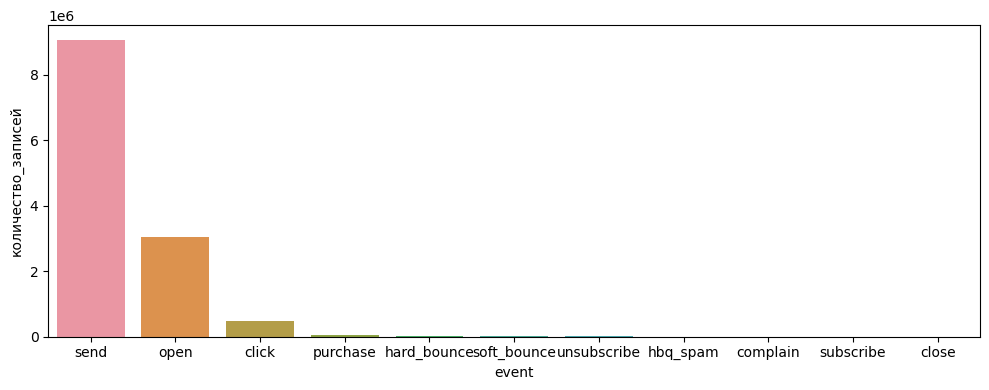

Число уникальных значений признака channel составляет 2
       channel  количество_записей  Percentage
0  mobile_push             7470472   58.863457
1        email             5220716   41.136543


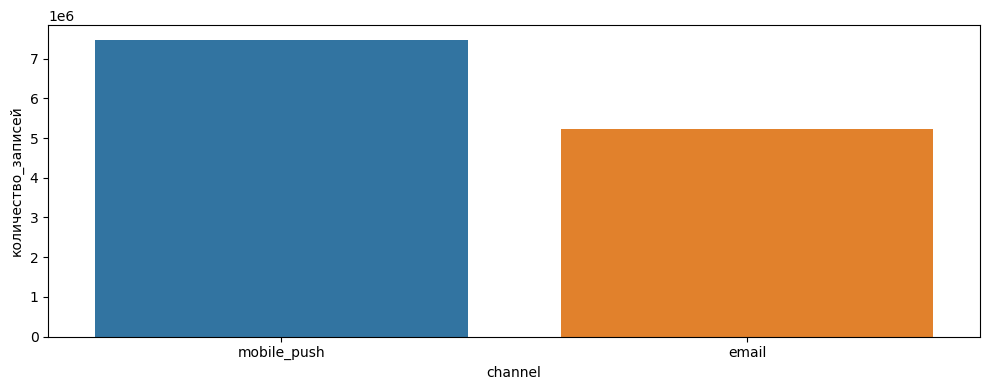

In [46]:
category_exploration(df_mess, mess_cat_cols)

In [47]:
tar_cat_cols = ['target']

Число уникальных значений признака target составляет 2
   target  количество_записей  Percentage
0       0               48888   98.072178
1       1                 961    1.927822


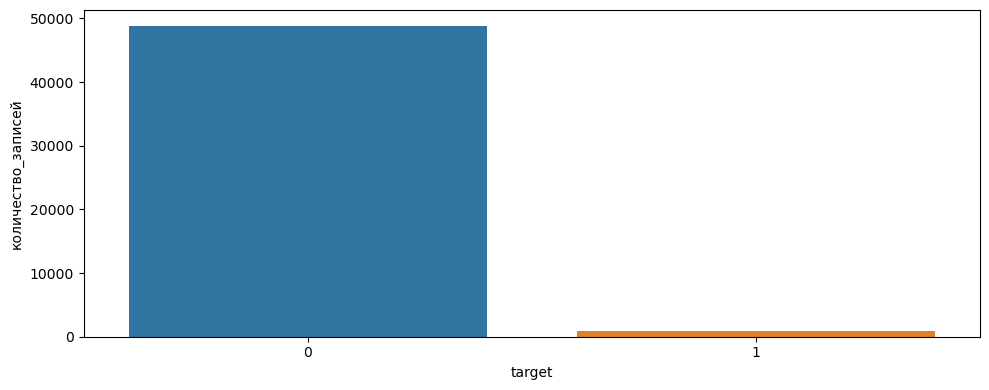

In [48]:
category_exploration(df_tar, tar_cat_cols)

Выполнено исследование состава признаков. Исключены выбросы по цене и количеству покупок.

### Подбор признаков

In [49]:
#сумма за покупку в данной категории
df_purch['sum_price'] = df_purch['quantity'] * df_purch['price']

In [50]:
df_purch.head()

,client_id,quantity,price,category_ids,date,message_id,category_0,category_1,category_2,category_3,category_4,sum_price
0,1515915625468169594,1,1999.0,"[4, 28, 57, 431]",2022-05-16,1515915625468169594-4301-627b661e9736d,4,28,57,431,0,1999.0
1,1515915625468169594,1,2499.0,"[4, 28, 57, 431]",2022-05-16,1515915625468169594-4301-627b661e9736d,4,28,57,431,0,2499.0
2,1515915625471138230,1,6499.0,"[4, 28, 57, 431]",2022-05-16,1515915625471138230-4437-6282242f27843,4,28,57,431,0,6499.0
3,1515915625471138230,1,4999.0,"[4, 28, 244, 432]",2022-05-16,1515915625471138230-4437-6282242f27843,4,28,244,432,0,4999.0
4,1515915625471138230,1,4999.0,"[4, 28, 49, 413]",2022-05-16,1515915625471138230-4437-6282242f27843,4,28,49,413,0,4999.0


In [51]:
#уровень категории для построения сводной таблицы по количеству товара 
#и сумме потраченных денег покупателем в разрезе категорий данного уровня
#можно менять для обучения моделей
cat_col = 'category_0'

In [52]:
#признак: количество купленного товара в разрезе категорий
purch_cnt_cat = df_purch.pivot_table(index='client_id', columns=cat_col, values='quantity', aggfunc='sum').reset_index()
purch_cnt_cat.columns = [cat_col + "_cnt_" + str(x) for x in purch_cnt_cat.columns]
purch_cnt_cat = purch_cnt_cat.fillna(0)

In [53]:
purch_cnt_cat

,category_0_cnt_client_id,category_0_cnt_0,category_0_cnt_1,category_0_cnt_2,category_0_cnt_3,category_0_cnt_4,category_0_cnt_5,category_0_cnt_5562,category_0_cnt_5963,category_0_cnt_6060
0,1515915625468060902,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0
1,1515915625468061003,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0
2,1515915625468061099,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,1515915625468061100,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,1515915625468061170,1.0,0.0,1.0,0.0,6.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
49837,1515915626010261344,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
49838,1515915626010266132,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
49839,1515915626010439406,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
49840,1515915626010443527,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [54]:
purch_cnt_cat.columns

Index(['category_0_cnt_client_id', 'category_0_cnt_0', 'category_0_cnt_1',
       'category_0_cnt_2', 'category_0_cnt_3', 'category_0_cnt_4',
       'category_0_cnt_5', 'category_0_cnt_5562', 'category_0_cnt_5963',
       'category_0_cnt_6060'],
      dtype='object')

In [55]:
#признак: сумма потраченных денег в разрезе категорий
purch_sum_cat = df_purch.pivot_table(index='client_id', columns=cat_col, values='sum_price', aggfunc='sum').reset_index()
purch_sum_cat.columns = [cat_col + "_sum_" + str(x) for x in purch_sum_cat.columns]
purch_sum_cat = purch_sum_cat.fillna(0)

In [56]:
purch_sum_cat.columns

Index(['category_0_sum_client_id', 'category_0_sum_0', 'category_0_sum_1',
       'category_0_sum_2', 'category_0_sum_3', 'category_0_sum_4',
       'category_0_sum_5', 'category_0_sum_5562', 'category_0_sum_5963',
       'category_0_sum_6060'],
      dtype='object')

In [57]:
df_mess.head()

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52


In [58]:
#признак: число событий по рекламным сообщениям по каждому клитенту
mess_cnt_event = df_mess.pivot_table(index='client_id', columns='event', values='bulk_campaign_id', aggfunc='count').reset_index()
mess_cnt_event.columns = ["event_cnt_" + str(x) for x in mess_cnt_event.columns]
mess_cnt_event = mess_cnt_event.fillna(0)

In [59]:
mess_cnt_event

,event_cnt_client_id,event_cnt_click,event_cnt_close,event_cnt_complain,event_cnt_hard_bounce,event_cnt_hbq_spam,event_cnt_open,event_cnt_purchase,event_cnt_send,event_cnt_soft_bounce,event_cnt_subscribe,event_cnt_unsubscribe
0,1515915625468060902,10.0,0.0,0.0,0.0,0.0,35.0,5.0,126.0,0.0,0.0,1.0
1,1515915625468061003,5.0,0.0,0.0,0.0,0.0,5.0,1.0,154.0,0.0,0.0,0.0
2,1515915625468061099,8.0,0.0,0.0,2.0,0.0,51.0,0.0,215.0,0.0,0.0,0.0
3,1515915625468061100,1.0,0.0,0.0,1.0,0.0,157.0,1.0,267.0,1.0,0.0,0.0
4,1515915625468061170,16.0,0.0,0.0,0.0,0.0,31.0,3.0,243.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
53324,1515915626010183608,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0
53325,1515915626010221592,2.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0
53326,1515915626010234726,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
53327,1515915626010261344,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [60]:
#признак: число рекламных сообщений в разрезе видов
mess_cnt_channel = df_mess.pivot_table(index='client_id', columns='channel', values='bulk_campaign_id', aggfunc='count').reset_index()
mess_cnt_channel.columns = ["channel_cnt_" + str(x) for x in mess_cnt_channel.columns]
mess_cnt_channel = mess_cnt_channel.fillna(0)

In [61]:
mess_cnt_channel

,channel_cnt_client_id,channel_cnt_email,channel_cnt_mobile_push
0,1515915625468060902,177.0,0.0
1,1515915625468061003,165.0,0.0
2,1515915625468061099,182.0,94.0
3,1515915625468061100,0.0,428.0
4,1515915625468061170,202.0,91.0
...,...,...,...
53324,1515915626010183608,0.0,4.0
53325,1515915626010221592,0.0,6.0
53326,1515915626010234726,0.0,1.0
53327,1515915626010261344,0.0,3.0


In [62]:
#слияние таблиц по клиентам для построения общей таблицы с целевым признаком

In [63]:
df_tar_0 = df_tar.merge(purch_cnt_cat, left_on='client_id', right_on='category_0_cnt_client_id', how='left')

In [64]:
df_tar_1 = df_tar_0.merge(purch_sum_cat, left_on='client_id', right_on='category_0_sum_client_id', how='left')

In [65]:
df_tar_2 = df_tar_1.merge(mess_cnt_event, left_on='client_id', right_on='event_cnt_client_id', how='left')

In [66]:
df_tar_3 = df_tar_2.merge(mess_cnt_channel, left_on='client_id', right_on='channel_cnt_client_id', how='left')

In [67]:
df_tar_3.columns

Index(['client_id', 'target', 'category_0_cnt_client_id', 'category_0_cnt_0',
       'category_0_cnt_1', 'category_0_cnt_2', 'category_0_cnt_3',
       'category_0_cnt_4', 'category_0_cnt_5', 'category_0_cnt_5562',
       'category_0_cnt_5963', 'category_0_cnt_6060',
       'category_0_sum_client_id', 'category_0_sum_0', 'category_0_sum_1',
       'category_0_sum_2', 'category_0_sum_3', 'category_0_sum_4',
       'category_0_sum_5', 'category_0_sum_5562', 'category_0_sum_5963',
       'category_0_sum_6060', 'event_cnt_client_id', 'event_cnt_click',
       'event_cnt_close', 'event_cnt_complain', 'event_cnt_hard_bounce',
       'event_cnt_hbq_spam', 'event_cnt_open', 'event_cnt_purchase',
       'event_cnt_send', 'event_cnt_soft_bounce', 'event_cnt_subscribe',
       'event_cnt_unsubscribe', 'channel_cnt_client_id', 'channel_cnt_email',
       'channel_cnt_mobile_push'],
      dtype='object')

In [68]:
#максимальная дата покупки по каждому клиенту
purch_time = df_purch.pivot_table(index='client_id', values='date', aggfunc='max').reset_index()
purch_time.columns = [ "maxdatepur_" + str(x) for x in purch_time.columns]
purch_time = purch_time.fillna(0)

In [69]:
#максимальная дата рассылки сообщений по каждому клиенту
mess_time = df_mess.pivot_table(index='client_id', values='date', aggfunc='max').reset_index()
mess_time.columns = ["maxdateme_" + str(x) for x in mess_time.columns]
mess_time = mess_time.fillna(0)

In [70]:
diff_time = purch_time.merge(mess_time, left_on='maxdatepur_client_id', right_on='maxdateme_client_id', how='inner')

In [71]:
#признак: разница между датой последней рассылки и последней покупкой
diff_time['diff_time'] = (diff_time['maxdatepur_date'] - diff_time['maxdateme_date']).dt.days

In [72]:
diff_time

,maxdatepur_client_id,maxdatepur_date,maxdateme_client_id,maxdateme_date,diff_time
0,1515915625468060902,2022-05-27,1515915625468060902,2024-01-19,-602
1,1515915625468061003,2023-01-04,1515915625468061003,2024-02-13,-405
2,1515915625468061099,2022-05-17,1515915625468061099,2024-02-13,-637
3,1515915625468061100,2024-02-10,1515915625468061100,2024-02-15,-5
4,1515915625468061170,2023-06-17,1515915625468061170,2024-02-15,-243
...,...,...,...,...,...
41971,1515915626010079153,2024-02-13,1515915626010079153,2024-02-13,0
41972,1515915626010152263,2024-02-14,1515915626010152263,2024-02-14,0
41973,1515915626010183608,2024-02-13,1515915626010183608,2024-02-15,-2
41974,1515915626010221592,2024-02-16,1515915626010221592,2024-02-15,1


In [73]:
diff_time = diff_time.drop(['maxdatepur_date', 'maxdateme_date', 'maxdateme_client_id' ], axis=1)

In [74]:
#максимальная дата покупки по всему датасету (считаем как будто - это дата выгрузки)
max_date_shop = df_purch['date'].max()

In [75]:
#признак: число дней от даты выгрузки до последней даты покупки, т.е. как давно покупал клиент
purch_time['shoptime'] = (max_date_shop - purch_time['maxdatepur_date']).dt.days

In [76]:
purch_time = purch_time.drop(['maxdatepur_date'], axis=1)

In [77]:
df_tar_4 = df_tar_3.merge(purch_time, left_on='client_id', right_on='maxdatepur_client_id', how='left')

In [78]:
df_tar_4 = df_tar_4.drop(['maxdatepur_client_id'], axis=1)

In [79]:
df_tar_5 = df_tar_4.merge(diff_time, left_on='client_id', right_on='maxdatepur_client_id', how='left')

In [80]:
df_tar_5.head(10)

,client_id,target,category_0_cnt_client_id,category_0_cnt_0,category_0_cnt_1,category_0_cnt_2,category_0_cnt_3,category_0_cnt_4,category_0_cnt_5,category_0_cnt_5562,...,event_cnt_send,event_cnt_soft_bounce,event_cnt_subscribe,event_cnt_unsubscribe,channel_cnt_client_id,channel_cnt_email,channel_cnt_mobile_push,shoptime,maxdatepur_client_id,diff_time
0,1515915625468060902,0,1.515916e+18,0.0,0.0,0.0,0.0,5.0,0.0,0.0,...,126.0,0.0,0.0,1.0,1.515916e+18,177.0,0.0,630.0,1.515916e+18,-602.0
1,1515915625468061003,1,1.515916e+18,0.0,0.0,0.0,0.0,6.0,0.0,0.0,...,154.0,0.0,0.0,0.0,1.515916e+18,165.0,0.0,408.0,1.515916e+18,-405.0
2,1515915625468061099,0,1.515916e+18,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,215.0,0.0,0.0,0.0,1.515916e+18,182.0,94.0,640.0,1.515916e+18,-637.0
3,1515915625468061100,0,1.515916e+18,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,267.0,1.0,0.0,0.0,1.515916e+18,0.0,428.0,6.0,1.515916e+18,-5.0
4,1515915625468061170,0,1.515916e+18,1.0,0.0,1.0,0.0,6.0,0.0,0.0,...,243.0,0.0,0.0,0.0,1.515916e+18,202.0,91.0,244.0,1.515916e+18,-243.0
5,1515915625468061514,0,1.515916e+18,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,150.0,0.0,0.0,0.0,1.515916e+18,180.0,0.0,566.0,1.515916e+18,-563.0
6,1515915625468061877,0,1.515916e+18,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,173.0,0.0,0.0,0.0,1.515916e+18,67.0,162.0,546.0,1.515916e+18,-545.0
7,1515915625468061975,0,1.515916e+18,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,154.0,0.0,0.0,0.0,1.515916e+18,180.0,0.0,569.0,1.515916e+18,-566.0
8,1515915625468061994,0,1.515916e+18,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,346.0,0.0,0.0,0.0,1.515916e+18,96.0,282.0,429.0,1.515916e+18,-427.0
9,1515915625468062158,0,1.515916e+18,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,113.0,0.0,0.0,0.0,1.515916e+18,172.0,0.0,294.0,1.515916e+18,-291.0


In [81]:
df_purch.head()

,client_id,quantity,price,category_ids,date,message_id,category_0,category_1,category_2,category_3,category_4,sum_price
0,1515915625468169594,1,1999.0,"[4, 28, 57, 431]",2022-05-16,1515915625468169594-4301-627b661e9736d,4,28,57,431,0,1999.0
1,1515915625468169594,1,2499.0,"[4, 28, 57, 431]",2022-05-16,1515915625468169594-4301-627b661e9736d,4,28,57,431,0,2499.0
2,1515915625471138230,1,6499.0,"[4, 28, 57, 431]",2022-05-16,1515915625471138230-4437-6282242f27843,4,28,57,431,0,6499.0
3,1515915625471138230,1,4999.0,"[4, 28, 244, 432]",2022-05-16,1515915625471138230-4437-6282242f27843,4,28,244,432,0,4999.0
4,1515915625471138230,1,4999.0,"[4, 28, 49, 413]",2022-05-16,1515915625471138230-4437-6282242f27843,4,28,49,413,0,4999.0


In [82]:
#признак: продолжительность покупок клиентом 
dateshop = df_purch.pivot_table(index='client_id', values='date', aggfunc=['max', 'min']).reset_index()
dateshop.columns = ['client_id', 'max_date', 'min_date']
dateshop['long_life'] = (dateshop['max_date'] - dateshop['min_date']).dt.days
dateshop = dateshop.drop(['max_date', 'min_date'], axis = 1)
dateshop.head()

,client_id,long_life
0,1515915625468060902,0
1,1515915625468061003,0
2,1515915625468061099,0
3,1515915625468061100,0
4,1515915625468061170,83


In [83]:
df_tar_6 = df_tar_5.merge(dateshop, on='client_id', how='left')

In [84]:
#число покупок клиентом
cnt_shop = df_purch.pivot_table(index='client_id', values='date', aggfunc=lambda x: len(x.unique())).reset_index()
cnt_shop.columns = ['client_id', 'cnt_shop']

In [85]:
cnt_shop

,client_id,cnt_shop
0,1515915625468060902,1
1,1515915625468061003,1
2,1515915625468061099,1
3,1515915625468061100,1
4,1515915625468061170,3
...,...,...
49837,1515915626010261344,1
49838,1515915626010266132,1
49839,1515915626010439406,1
49840,1515915626010443527,1


In [86]:
df_tar_7 = df_tar_6.merge(cnt_shop, on='client_id', how='left')

In [87]:
df_tar_7

,client_id,target,category_0_cnt_client_id,category_0_cnt_0,category_0_cnt_1,category_0_cnt_2,category_0_cnt_3,category_0_cnt_4,category_0_cnt_5,category_0_cnt_5562,...,event_cnt_subscribe,event_cnt_unsubscribe,channel_cnt_client_id,channel_cnt_email,channel_cnt_mobile_push,shoptime,maxdatepur_client_id,diff_time,long_life,cnt_shop
0,1515915625468060902,0,1.515916e+18,0.0,0.0,0.0,0.0,5.0,0.0,0.0,...,0.0,1.0,1.515916e+18,177.0,0.0,630.0,1.515916e+18,-602.0,0.0,1.0
1,1515915625468061003,1,1.515916e+18,0.0,0.0,0.0,0.0,6.0,0.0,0.0,...,0.0,0.0,1.515916e+18,165.0,0.0,408.0,1.515916e+18,-405.0,0.0,1.0
2,1515915625468061099,0,1.515916e+18,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.515916e+18,182.0,94.0,640.0,1.515916e+18,-637.0,0.0,1.0
3,1515915625468061100,0,1.515916e+18,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.515916e+18,0.0,428.0,6.0,1.515916e+18,-5.0,0.0,1.0
4,1515915625468061170,0,1.515916e+18,1.0,0.0,1.0,0.0,6.0,0.0,0.0,...,0.0,0.0,1.515916e+18,202.0,91.0,244.0,1.515916e+18,-243.0,83.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49844,1515915626010261344,0,1.515916e+18,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.515916e+18,0.0,3.0,0.0,1.515916e+18,1.0,0.0,1.0
49845,1515915626010266132,0,1.515916e+18,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,0.0,1.0
49846,1515915626010439406,0,1.515916e+18,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,1.0
49847,1515915626010443527,0,1.515916e+18,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,1.0


В результате анализа датасетов были добавлены следующие признаки:
- сумма за покупку в разрезе категории заданного уровня
- количество купленного товара в разрезе категорий
- сумма потраченных клиентом денег в разрезе категорий
- число событий по рекламным сообщениям по каждому клитенту
- число рекламных сообщений в разрезе видов
- число дней между датой последней рассылки и последней покупкой
- число дней от даты выгрузки до последней даты покупки
- продолжительность покупок клиентом 
- число покупок клиентом

### Корреляционный анализ

In [88]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [89]:
df_target = df_tar_7.drop(['category_0_cnt_client_id', 'category_0_sum_client_id', 'event_cnt_client_id', 'channel_cnt_client_id', 'maxdatepur_client_id'], axis=1)

In [90]:
df_target.head()

,client_id,target,category_0_cnt_0,category_0_cnt_1,category_0_cnt_2,category_0_cnt_3,category_0_cnt_4,category_0_cnt_5,category_0_cnt_5562,category_0_cnt_5963,category_0_cnt_6060,category_0_sum_0,category_0_sum_1,category_0_sum_2,category_0_sum_3,category_0_sum_4,category_0_sum_5,category_0_sum_5562,category_0_sum_5963,category_0_sum_6060,event_cnt_click,event_cnt_close,event_cnt_complain,event_cnt_hard_bounce,event_cnt_hbq_spam,event_cnt_open,event_cnt_purchase,event_cnt_send,event_cnt_soft_bounce,event_cnt_subscribe,event_cnt_unsubscribe,channel_cnt_email,channel_cnt_mobile_push,shoptime,diff_time,long_life,cnt_shop
0,1515915625468060902,0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4795.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,35.0,5.0,126.0,0.0,0.0,1.0,177.0,0.0,630.0,-602.0,0.0,1.0
1,1515915625468061003,1,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14135.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,5.0,1.0,154.0,0.0,0.0,0.0,165.0,0.0,408.0,-405.0,0.0,1.0
2,1515915625468061099,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,299.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,2.0,0.0,51.0,0.0,215.0,0.0,0.0,0.0,182.0,94.0,640.0,-637.0,0.0,1.0
3,1515915625468061100,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1049.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,157.0,1.0,267.0,1.0,0.0,0.0,0.0,428.0,6.0,-5.0,0.0,1.0
4,1515915625468061170,0,1.0,0.0,1.0,0.0,6.0,0.0,0.0,0.0,0.0,7.0,0.0,2699.0,0.0,11396.0,0.0,0.0,0.0,0.0,16.0,0.0,0.0,0.0,0.0,31.0,3.0,243.0,0.0,0.0,0.0,202.0,91.0,244.0,-243.0,83.0,3.0


In [91]:
df_target.phik_matrix()

interval columns not set, guessing: ['client_id', 'target', 'category_0_cnt_0', 'category_0_cnt_1', 'category_0_cnt_2', 'category_0_cnt_3', 'category_0_cnt_4', 'category_0_cnt_5', 'category_0_cnt_5562', 'category_0_cnt_5963', 'category_0_cnt_6060', 'category_0_sum_0', 'category_0_sum_1', 'category_0_sum_2', 'category_0_sum_3', 'category_0_sum_4', 'category_0_sum_5', 'category_0_sum_5562', 'category_0_sum_5963', 'category_0_sum_6060', 'event_cnt_click', 'event_cnt_close', 'event_cnt_complain', 'event_cnt_hard_bounce', 'event_cnt_hbq_spam', 'event_cnt_open', 'event_cnt_purchase', 'event_cnt_send', 'event_cnt_soft_bounce', 'event_cnt_subscribe', 'event_cnt_unsubscribe', 'channel_cnt_email', 'channel_cnt_mobile_push', 'shoptime', 'diff_time', 'long_life', 'cnt_shop']


,client_id,target,category_0_cnt_0,category_0_cnt_1,category_0_cnt_2,category_0_cnt_3,category_0_cnt_4,category_0_cnt_5,category_0_cnt_5562,category_0_cnt_5963,category_0_cnt_6060,category_0_sum_0,category_0_sum_1,category_0_sum_2,category_0_sum_3,category_0_sum_4,category_0_sum_5,category_0_sum_5562,category_0_sum_5963,category_0_sum_6060,event_cnt_click,event_cnt_close,event_cnt_complain,event_cnt_hard_bounce,event_cnt_hbq_spam,event_cnt_open,event_cnt_purchase,event_cnt_send,event_cnt_soft_bounce,event_cnt_subscribe,event_cnt_unsubscribe,channel_cnt_email,channel_cnt_mobile_push,shoptime,diff_time,long_life,cnt_shop
client_id,1.000000,0.019167,0.034442,0.011942,0.017550,0.022999,0.026404,0.000000,0.018833,0.018688,0.027571,0.004298,0.020842,0.031371,0.042052,0.000000,0.000000,0.029560,0.009250,0.023226,0.032767,0.008502,0.000000,0.028313,0.048548,0.083551,0.000000,0.172369,0.000000,0.000000,0.048824,0.305692,0.121694,0.412083,0.352002,0.099365,0.028015
target,0.019167,1.000000,0.026593,0.000000,0.005947,0.000000,0.102360,0.000000,0.046610,0.000000,0.020661,0.018861,0.000000,0.000000,0.000000,0.045965,0.000000,0.019103,0.000000,0.010270,0.074659,0.000000,0.000000,0.032308,0.000000,0.060221,0.073965,0.057655,0.000000,0.013967,0.017538,0.023411,0.067091,0.115984,0.081184,0.134140,0.074334
category_0_cnt_0,0.034442,0.026593,1.000000,0.000000,0.086732,0.000000,0.125512,0.100798,0.088616,0.022572,0.080893,0.942214,0.000000,0.100879,0.000000,0.412200,0.100798,0.067720,0.020204,0.078270,0.064895,0.000000,0.000000,0.000000,0.000000,0.000000,0.355818,0.000000,0.000000,0.000000,0.000000,0.007951,0.000000,0.132460,0.131488,0.081011,0.271993
category_0_cnt_1,0.011942,0.000000,0.000000,1.000000,0.015753,0.000000,0.032440,0.000000,0.375658,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.079736,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.241386,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.041179,0.117165
category_0_cnt_2,0.017550,0.005947,0.086732,0.015753,1.000000,0.000000,0.636450,0.000000,0.044693,0.000000,0.636055,0.000000,0.051060,0.815695,0.000000,0.180932,0.000000,0.035071,0.000000,0.414848,0.059538,0.000000,0.000000,0.144702,0.000000,0.000000,0.205805,0.000000,0.000000,0.000000,0.025821,0.018345,0.000000,0.041079,0.030685,0.126624,0.645969
category_0_cnt_3,0.022999,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.056299,0.000000,0.000000,0.000000,0.000000,0.000000,0.683477,0.000000,0.000000,0.012777,0.000000,0.028493,0.000000,0.000000,0.000000,0.000000,0.000000,0.006850,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007604,0.011616,0.000000,0.009707,0.021049
category_0_cnt_4,0.026404,0.102360,0.125512,0.032440,0.636450,0.000000,1.000000,0.000000,0.170974,0.148115,0.793808,0.050379,0.050382,0.663549,0.000000,0.705216,0.000000,0.000000,0.122016,0.564403,0.096768,0.000000,0.000000,0.000000,0.000000,0.020568,0.485842,0.000000,0.008375,0.151909,0.085230,0.042384,0.009125,0.052160,0.049504,0.177011,0.712009
category_0_cnt_5,0.000000,0.000000,0.100798,0.000000,0.000000,0.000000,0.000000,1.000000,0.084016,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.707080,0.044491,0.000000,0.000000,0.021535,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.019057,0.000000,0.000000,0.000000,0.035835,0.057934
category_0_cnt_5562,0.018833,0.046610,0.088616,0.375658,0.044693,0.056299,0.170974,0.084016,1.000000,0.082886,0.056216,0.000000,0.506995,0.000000,0.080937,0.000000,0.084016,0.398063,0.028124,0.000000,0.118607,0.000000,0.000000,0.000000,0.000000,0.024947,0.447031,0.051510,0.000000,0.000000,0.000000,0.038909,0.077709,0.099035,0.089216,0.156641,0.230348
category_0_cnt_5963,0.018688,0.000000,0.022572,0.000000,0.000000,0.000000,0.148115,0.000000,0.082886,1.000000,0.105485,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.941506,0.081557,0.000000,0.000000,0.000000,0.000000,0

In [92]:
pd.reset_option('display.max_columns')
pd.reset_option('display.max_rows')

В результате корреляционного анализа установлено:
- влияние на целевой признак: число дней от даты выгрузки до последней даты покупки, продолжительность покупок покупателем
- установлена высокая корреляция между признаками: число дней от даты выгрузки до последней даты покупки, продолжительность покупок покупателем
- есть нулевая корреляция между целевым признаком и числом, суммой покупок по отдельными категориям, а также между целевым признаком и отдельными событиями пользователей на рекламные сообщения

### Оптимизация числовых признаков

In [93]:
# Оптимизация числовых типов данных
def optimize_memory_usage(df: pd.DataFrame, print_size: bool=True) -> pd.DataFrame:
    '''
    Function optimizes memory usage in dataframe
    df: pd.DataFrame - data table
    print_size: bool - display of optimization results
    return pd.DataFrame - amount of optimized memory
    '''
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64'] # Типы, которые будем проверять на оптимизацию
    # Размер занимаемой памяти до оптимизации (в Мб)
    before_size = df.memory_usage().sum() / 1024**2    
    for column in df.columns:
        column_type = df[column].dtypes
        if column_type in numerics:
            column_min = df[column].min()
            column_max = df[column].max()
            if str(column_type).startswith('int'):
                if column_min > np.iinfo(np.int8).min and column_max < np.iinfo(np.int8).max:
                    df[column] = df[column].astype(np.int8)
                elif column_min > np.iinfo(np.int16).min and column_max < np.iinfo(np.int16).max:
                    df[column] = df[column].astype(np.int16)
                elif column_min > np.iinfo(np.int32).min and column_max < np.iinfo(np.int32).max:
                    df[column] = df[column].astype(np.int32)
                elif column_min > np.iinfo(np.int64).min and column_max < np.iinfo(np.int64).max:
                    df[column] = df[column].astype(np.int64)  
            else:
                if column_min > np.finfo(np.float32).min and column_max < np.finfo(np.float32).max:
                    df[column] = df[column].astype(np.float32)
                else:
                    df[column] = df[column].astype(np.float64)    
    # Размер занимаемой памяти после оптимизации (в Мб)
    after_size = df.memory_usage().sum() / 1024**2
    if print_size: print('Размер использования памяти: до {:5.2f} Mb - после {:5.2f} Mb ({:.1f}%)'
                         .format(before_size, after_size, 100 * (before_size - after_size) / before_size))
    return df

In [94]:
df_target = optimize_memory_usage(df_target, True)

Размер использования памяти: до 14.45 Mb - после  7.46 Mb (48.4%)


## Подготовка данных для обучения

In [95]:
target = 'target'
exclude = ['category_3_cnt_8', 'category_3_cnt_10', 'category_3_cnt_12', 'category_3_cnt_14', 'category_3_cnt_22',\
           'category_1_sum_8', 'category_1_sum_10', 'category_1_sum_12', 'category_1_sum_14', 'category_1_sum_22',\
            'event_cnt_close']

In [96]:
X = df_target.drop(['client_id', 'target'], axis = 1)

In [97]:
data_info(X,'Данные для моделей')

Информация о столбцах таблицы  Данные для моделей
<class 'pandas.core.frame.DataFrame'>
Int64Index: 49849 entries, 0 to 49848
Data columns (total 35 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   category_0_cnt_0         49842 non-null  float32
 1   category_0_cnt_1         49842 non-null  float32
 2   category_0_cnt_2         49842 non-null  float32
 3   category_0_cnt_3         49842 non-null  float32
 4   category_0_cnt_4         49842 non-null  float32
 5   category_0_cnt_5         49842 non-null  float32
 6   category_0_cnt_5562      49842 non-null  float32
 7   category_0_cnt_5963      49842 non-null  float32
 8   category_0_cnt_6060      49842 non-null  float32
 9   category_0_sum_0         49842 non-null  float32
 10  category_0_sum_1         49842 non-null  float32
 11  category_0_sum_2         49842 non-null  float32
 12  category_0_sum_3         49842 non-null  float32
 13  category_0_sum_4         4

None

Количество незаполненных значений в полях:
category_0_cnt_0              7
category_0_cnt_1              7
category_0_cnt_2              7
category_0_cnt_3              7
category_0_cnt_4              7
category_0_cnt_5              7
category_0_cnt_5562           7
category_0_cnt_5963           7
category_0_cnt_6060           7
category_0_sum_0              7
category_0_sum_1              7
category_0_sum_2              7
category_0_sum_3              7
category_0_sum_4              7
category_0_sum_5              7
category_0_sum_5562           7
category_0_sum_5963           7
category_0_sum_6060           7
event_cnt_click            7867
event_cnt_close            7867
event_cnt_complain         7867
event_cnt_hard_bounce      7867
event_cnt_hbq_spam         7867
event_cnt_open             7867
event_cnt_purchase         7867
event_cnt_send             7867
event_cnt_soft_bounce      7867
event_cnt_subscribe        7867
event_cnt_unsubscribe      7867
channel_cnt_email          78

In [98]:
df_target = df_target[~X.duplicated()]

In [99]:
X = df_target.drop([target], axis = 1)
y = df_target[target]

In [101]:
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = y
    )

In [102]:
def make_rating(df, df_train, df_test):
    cat = 'category_3'
    train_ = df_train.merge(df.loc[:, ['client_id', cat, 'date']], on='client_id', how='inner')
    rating = train_[cat].value_counts().sort_index()
    
    train_['rating'] = train_[cat].apply(lambda x: rating[x]).astype(int)
    last_cat_train = (train_
            .pivot_table(index=['client_id','rating'], values='date', aggfunc='max')
            .reset_index()
            .pivot_table(index=['client_id'], values='rating', aggfunc='max')
            .reset_index())
    df_train = df_train.merge(last_cat_train.loc[:,['client_id','rating']], on='client_id', how='left')
    
    test_ = df_test.merge(df.loc[:, ['client_id', cat, 'date']], on='client_id', how='inner')
    test_['rating'] = test_[cat].apply(lambda x: rating[x] if any(x == rating.index) else 0).astype(int)
    last_cat_test = (test_
            .pivot_table(index=['client_id','rating'], values='date', aggfunc='max')
            .reset_index()
            .pivot_table(index=['client_id'], values='rating', aggfunc='max')
            .reset_index())
    df_test = df_test.merge(last_cat_test.loc[:,['client_id','rating']], on='client_id', how='left')
    
    return df_train, df_test

In [103]:
X_train, X_test = make_rating(df_purch, X_train, X_test)

In [104]:
X_train = X_train.drop(['client_id'], axis = 1)

In [105]:
X_test = X_test.drop(['client_id'], axis = 1)

Выполнено разделение выборки на тренировочную и тестовую. Также введен новый признак - наиболее часто покупаемая категория товара последней покупки. Частота (рейтинг) покупок определена на тренировочной выборке.

In [106]:
#исключение малозначимых признаков эффекта не дает
#z = ['shoptime', 'event_cnt_click', 'event_cnt_open', 'channel_cnt_email', 'channel_cnt_mobile_push',\
# 'diff_time', 'category_0_sum_5562', 'cnt_shop', 'long_life', 'event_cnt_send', 'category_0_sum_4',\
# 'category_0_sum_2', 'event_cnt_unsubscribe', 'category_0_cnt_4', 'category_0_cnt_2', 'event_cnt_purchase',\
# 'category_0_sum_6060', 'event_cnt_hard_bounce', 'category_0_cnt_5562', 'category_0_sum_0', 'event_cnt_hbq_spam',\
# 'category_0_sum_5963', 'category_0_cnt_6060', 'category_0_cnt_0', 'category_0_cnt_5963', 'event_cnt_complain',\
# 'event_cnt_soft_bounce', 'event_cnt_subscribe']


In [107]:
#X_train = X_train.loc[:,z]

In [108]:
#X_test = X_test.loc[:,z]

## Анализ моделей

In [109]:
def present_result(df_res, X_test, y_test):
    df_res = df_res.sort_values(by='roc_auc', ascending=False).reset_index(drop=True)
    print('Результаты лучших моделей:')
    display(df_res)
    print('Лучшая модель из лучших:')
    display(df_res.loc[0,'best_estimator'])
    y_test_pred = df_res.loc[0,'best_estimator'].predict(X_test)
    print(f'Метрика Roc_auc на тестовой выборке для самой лучшей модели: {roc_auc_score(y_test, y_test_pred)}')
    return df_res

In [110]:
def best_among_class_model(pipe_final, param_grid, X_train, y_train):
    grid = GridSearchCV(
            pipe_final, 
            param_grid=param_grid, 
            cv=10, 
            scoring='roc_auc', 
            n_jobs = -1,
            error_score='raise'
    )
    grid.fit(X_train, y_train)
    df_res = pd.DataFrame(grid.cv_results_).sort_values(by='mean_test_score', ascending=False).reset_index(drop=True)
    return [grid.best_estimator_,grid.best_estimator_.named_steps['models'], grid.best_score_, df_res.loc[0,'mean_fit_time'], df_res.loc[0,'mean_score_time']]

In [111]:
df_res = pd.DataFrame(columns=['best_estimator', 'model', 'roc_auc', 'mean_fit_time', 'mean_score_time'])

### Обучение деревьев решений

In [137]:
def change_type_int(df):
    if 'rating' in df.columns:
        df['rating'] = df['rating'].astype(int)
    return df

In [138]:
# создаём пайплайн для подготовки признаков
num_pipe_int = Pipeline(
    [
     #('sc', MinMaxScaler()),
     ('simpleImputer_num', SimpleImputer(missing_values=np.nan, strategy='median')),
     ('ch_cat',FunctionTransformer(change_type_int) )
    ]
    )
num_pipe_int.set_output(transform="pandas")

Pipeline(steps=[('simpleImputer_num', SimpleImputer(strategy='median')),
                ('ch_cat',
                 FunctionTransformer(func=<function change_type_int at 0x0000023E93087F70>))])

In [139]:
# создаем итоговый пайплайн: подготовка данных и модель
pipe_final_tree = Pipeline(
    [
        ('preprocessor', num_pipe_int),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE, \
        max_depth = 5, max_features = 5, class_weight='balanced'))
    ]
)
param_grid_tree = [
     # словарь для модели DecisionTreeRegressor()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)], #, class_weight='balanced'
        'models__max_depth': [5,10,15,20,25],
        'models__max_features': [5,10,15,20,25,30,40],
        'models__min_samples_leaf': [5,7,10]
    }    
]

In [140]:
res_tree = best_among_class_model(pipe_final_tree, param_grid_tree, X_train, y_train)

In [141]:
df_res.loc[ len(df_res.index )] = res_tree

### Обучение модели LightGBM

In [142]:
def change_type_cat(df):
    if 'rating' in df.columns:
        df['rating'] = df['rating'].astype('category')
    return df

In [143]:
# создаём пайплайн для подготовки признаков
num_pipe_cat = Pipeline(
    [
     #('sc', MinMaxScaler()),
     ('simpleImputer_num', SimpleImputer(missing_values=np.nan, strategy='median')),
     ('ch_cat',FunctionTransformer(change_type_cat) )
    ]
    )
num_pipe_cat.set_output(transform="pandas")

Pipeline(steps=[('simpleImputer_num', SimpleImputer(strategy='median')),
                ('ch_cat',
                 FunctionTransformer(func=<function change_type_cat at 0x0000023E8E73B4C0>))])

In [144]:
# создаем итоговый пайплайн: подготовка данных и модель
pipe_final_gbm = Pipeline(
    [
        ('preprocessor', num_pipe_cat),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE, \
        max_depth = 5, max_features = 5, class_weight='balanced'))
    ]
)
param_grid_gbm = [
  
     # словарь для модели LGBMClassifier() 
    {
        'models': [LGBMClassifier(random_state=RANDOM_STATE)],# , is_unbalance=True
        'models__max_depth': np.arange(3,16,2),
        'models__num_leaves': np.arange(5,20,2),
        'models__n_estimators': [8,10,16,24,30,32,40,48]
    }   
    
]

In [145]:
res_gbm = best_among_class_model(pipe_final_gbm, param_grid_gbm, X_train, y_train)

[LightGBM] [Info] Number of positive: 720, number of negative: 36320
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007098 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3496
[LightGBM] [Info] Number of data points in the train set: 37040, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.019438 -> initscore=-3.920873
[LightGBM] [Info] Start training from score -3.920873


In [146]:
df_res.loc[ len(df_res.index )] = res_gbm

### Обучение модели CatBoost

In [147]:
def change_type_obj(df):
    if 'rating' in df.columns:
        df['rating'] = df['rating'].astype(int)
    return df

In [148]:
# создаём пайплайн для подготовки признаков
num_pipe_obj = Pipeline(
    [
     #('sc', MinMaxScaler()),
     ('simpleImputer_num', SimpleImputer(missing_values=np.nan, strategy='median')),
     ('ch_cat',FunctionTransformer(change_type_obj) )
    ]
    )
num_pipe_obj.set_output(transform="pandas")

Pipeline(steps=[('simpleImputer_num', SimpleImputer(strategy='median')),
                ('ch_cat',
                 FunctionTransformer(func=<function change_type_obj at 0x0000023E8E7EBF70>))])

In [149]:
# создаем итоговый пайплайн: подготовка данных и модель
pipe_final_cat = Pipeline(
    [
        ('preprocessor', num_pipe_obj),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE, \
        max_depth = 5, max_features = 5)) #, class_weight='balanced'
    ]
)
param_grid_cat = [
   
    {#, cat_features = ['rating']
        'models': [CatBoostClassifier(random_state=RANDOM_STATE, auto_class_weights='Balanced',
                                     iterations=200)],
        'models__depth': [6, 10],
        'models__learning_rate': [0.01, 0.1]
    }
    
    
]

In [150]:
res_cat = best_among_class_model(pipe_final_cat, param_grid_cat, X_train, y_train)

0:	learn: 0.6915309	total: 11.6ms	remaining: 2.3s
1:	learn: 0.6901041	total: 21.1ms	remaining: 2.08s
2:	learn: 0.6885535	total: 30ms	remaining: 1.97s
3:	learn: 0.6870593	total: 39.2ms	remaining: 1.92s
4:	learn: 0.6857256	total: 48.4ms	remaining: 1.89s
5:	learn: 0.6841505	total: 57.8ms	remaining: 1.87s
6:	learn: 0.6825649	total: 66.8ms	remaining: 1.84s
7:	learn: 0.6813401	total: 75.8ms	remaining: 1.82s
8:	learn: 0.6798327	total: 84.9ms	remaining: 1.8s
9:	learn: 0.6784550	total: 93.8ms	remaining: 1.78s
10:	learn: 0.6769102	total: 103ms	remaining: 1.77s
11:	learn: 0.6755616	total: 112ms	remaining: 1.75s
12:	learn: 0.6742354	total: 121ms	remaining: 1.74s
13:	learn: 0.6730096	total: 130ms	remaining: 1.73s
14:	learn: 0.6718426	total: 140ms	remaining: 1.73s
15:	learn: 0.6707791	total: 151ms	remaining: 1.73s
16:	learn: 0.6695162	total: 161ms	remaining: 1.74s
17:	learn: 0.6681858	total: 171ms	remaining: 1.73s
18:	learn: 0.6668741	total: 181ms	remaining: 1.73s
19:	learn: 0.6659657	total: 192ms	r

176:	learn: 0.5888787	total: 1.68s	remaining: 218ms
177:	learn: 0.5886924	total: 1.69s	remaining: 209ms
178:	learn: 0.5883455	total: 1.7s	remaining: 200ms
179:	learn: 0.5881811	total: 1.71s	remaining: 190ms
180:	learn: 0.5879500	total: 1.72s	remaining: 181ms
181:	learn: 0.5877415	total: 1.73s	remaining: 171ms
182:	learn: 0.5875351	total: 1.74s	remaining: 162ms
183:	learn: 0.5873818	total: 1.75s	remaining: 153ms
184:	learn: 0.5871637	total: 1.76s	remaining: 143ms
185:	learn: 0.5869334	total: 1.77s	remaining: 133ms
186:	learn: 0.5867794	total: 1.78s	remaining: 124ms
187:	learn: 0.5866051	total: 1.79s	remaining: 114ms
188:	learn: 0.5861959	total: 1.8s	remaining: 105ms
189:	learn: 0.5858147	total: 1.81s	remaining: 95.3ms
190:	learn: 0.5855518	total: 1.82s	remaining: 85.8ms
191:	learn: 0.5853604	total: 1.83s	remaining: 76.3ms
192:	learn: 0.5849990	total: 1.84s	remaining: 66.7ms
193:	learn: 0.5848026	total: 1.85s	remaining: 57.2ms
194:	learn: 0.5845340	total: 1.86s	remaining: 47.6ms
195:	lea

In [151]:
df_res.loc[ len(df_res.index )] = res_cat

In [152]:
df_res = present_result(df_res, X_test, y_test)
df_res

Результаты лучших моделей:


,best_estimator,model,roc_auc,mean_fit_time,mean_score_time
0,"((SimpleImputer(strategy='median'), FunctionTr...",<catboost.core.CatBoostClassifier object at 0x...,0.736816,21.008687,0.036380
1,"((SimpleImputer(strategy='median'), FunctionTr...",<catboost.core.CatBoostClassifier object at 0x...,0.736816,20.204970,0.039340
2,"((SimpleImputer(strategy='median'), FunctionTr...","LGBMClassifier(max_depth=3, n_estimators=16, n...",0.705710,1.447119,0.022710
3,"((SimpleImputer(strategy='median'), FunctionTr...",DecisionTreeClassifier(class_weight='balanced'...,0.690034,0.491832,0.021960
4,"((SimpleImputer(strategy='median'), FunctionTr...","LGBMClassifier(is_unbalance=True, max_depth=3,...",0.689423,1.598962,0.022356
5,"((SimpleImputer(strategy='median'), FunctionTr...","DecisionTreeClassifier(max_depth=5, max_featur...",0.680469,0.373970,0.018302


Лучшая модель из лучших:


Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('simpleImputer_num',
                                  SimpleImputer(strategy='median')),
                                 ('ch_cat',
                                  FunctionTransformer(func=<function change_type_obj at 0x0000023E8E73BAF0>))])),
                ('models',
                 <catboost.core.CatBoostClassifier object at 0x0000023E8E7E88E0>)])

Метрика Roc_auc на тестовой выборке для самой лучшей модели: 0.7062117989592797


,best_estimator,model,roc_auc,mean_fit_time,mean_score_time
0,"((SimpleImputer(strategy='median'), FunctionTr...",<catboost.core.CatBoostClassifier object at 0x...,0.736816,21.008687,0.036380
1,"((SimpleImputer(strategy='median'), FunctionTr...",<catboost.core.CatBoostClassifier object at 0x...,0.736816,20.204970,0.039340
2,"((SimpleImputer(strategy='median'), FunctionTr...","LGBMClassifier(max_depth=3, n_estimators=16, n...",0.705710,1.447119,0.022710
3,"((SimpleImputer(strategy='median'), FunctionTr...",DecisionTreeClassifier(class_weight='balanced'...,0.690034,0.491832,0.021960
4,"((SimpleImputer(strategy='median'), FunctionTr...","LGBMClassifier(is_unbalance=True, max_depth=3,...",0.689423,1.598962,0.022356
5,"((SimpleImputer(strategy='median'), FunctionTr...","DecisionTreeClassifier(max_depth=5, max_featur...",0.680469,0.373970,0.018302


Выполнено обучение трех моделей: деревьев решений, моделей градиентного бустинга LightGBM, CatBoost. Лучшей оказалась CatBoost.

## Анализ признаков

In [153]:
best_pl = df_res.loc[0,'best_estimator']
#best_pl = grid
X_test_scalled = pd.DataFrame(best_pl.named_steps['preprocessor'].transform(X_test))
X_train_scalled = pd.DataFrame(best_pl.named_steps['preprocessor'].transform(X_train))
best_model = df_res.loc[0,'model']
print(best_model)

In [154]:
X_test_scalled.columns = [ x[0:50] for x in X_train.columns]
X_train_scalled.columns = X_test_scalled.columns
X_test_scalled.columns

Index(['category_0_cnt_0', 'category_0_cnt_1', 'category_0_cnt_2',
       'category_0_cnt_3', 'category_0_cnt_4', 'category_0_cnt_5',
       'category_0_cnt_5562', 'category_0_cnt_5963', 'category_0_cnt_6060',
       'category_0_sum_0', 'category_0_sum_1', 'category_0_sum_2',
       'category_0_sum_3', 'category_0_sum_4', 'category_0_sum_5',
       'category_0_sum_5562', 'category_0_sum_5963', 'category_0_sum_6060',
       'event_cnt_click', 'event_cnt_close', 'event_cnt_complain',
       'event_cnt_hard_bounce', 'event_cnt_hbq_spam', 'event_cnt_open',
       'event_cnt_purchase', 'event_cnt_send', 'event_cnt_soft_bounce',
       'event_cnt_subscribe', 'event_cnt_unsubscribe', 'channel_cnt_email',
       'channel_cnt_mobile_push', 'shoptime', 'diff_time', 'long_life',
       'cnt_shop', 'rating'],
      dtype='object')

In [155]:
feature_importance = best_model.get_feature_importance()
feature_names = X_train_scalled.columns
feature_zip = sorted(zip(feature_names, feature_importance), key=lambda x: x[1], reverse=True)

# Display feature importance
for name, importance in feature_zip:
    print(f"Feature: {name}, Importance: {importance:.2f}")

Feature: shoptime, Importance: 23.49
Feature: event_cnt_click, Importance: 12.76
Feature: long_life, Importance: 8.34
Feature: channel_cnt_mobile_push, Importance: 8.16
Feature: diff_time, Importance: 7.27
Feature: event_cnt_open, Importance: 6.78
Feature: cnt_shop, Importance: 6.61
Feature: event_cnt_unsubscribe, Importance: 2.96
Feature: category_0_cnt_4, Importance: 2.83
Feature: event_cnt_send, Importance: 2.78
Feature: category_0_sum_5562, Importance: 2.75
Feature: channel_cnt_email, Importance: 2.58
Feature: category_0_sum_2, Importance: 2.49
Feature: rating, Importance: 1.90
Feature: category_0_sum_4, Importance: 1.75
Feature: event_cnt_purchase, Importance: 1.22
Feature: event_cnt_hbq_spam, Importance: 0.89
Feature: category_0_cnt_2, Importance: 0.79
Feature: category_0_sum_6060, Importance: 0.77
Feature: category_0_cnt_5562, Importance: 0.69
Feature: event_cnt_hard_bounce, Importance: 0.60
Feature: category_0_cnt_0, Importance: 0.49
Feature: category_0_sum_5963, Importance: 0.

In [156]:
feature_names, feature_importance = zip(*feature_zip)
feature_importance= list(feature_importance)
feature_names= list(feature_names)

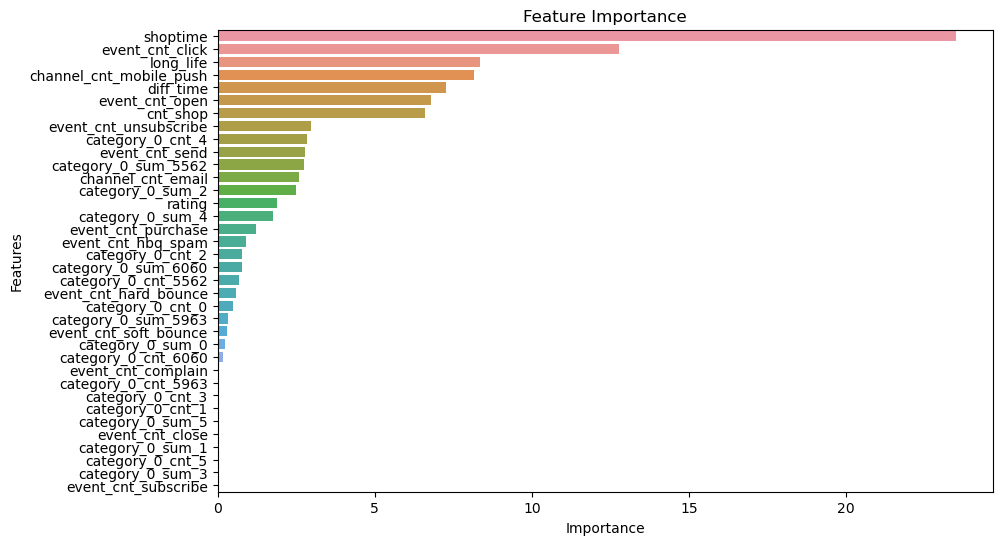

In [157]:
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance, y=feature_names)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

In [158]:
f = lambda x: best_model.predict_proba(x)[:,1]
med = X_train_scalled.median().values.reshape((1,X_train_scalled.shape[1]))
explainer = shap.KernelExplainer(f, med)
shap_values_norm = explainer.shap_values(X_test_scalled.iloc[0:1000,:], nsamples=1000)


  0%|          | 0/1000 [00:00<?, ?it/s]

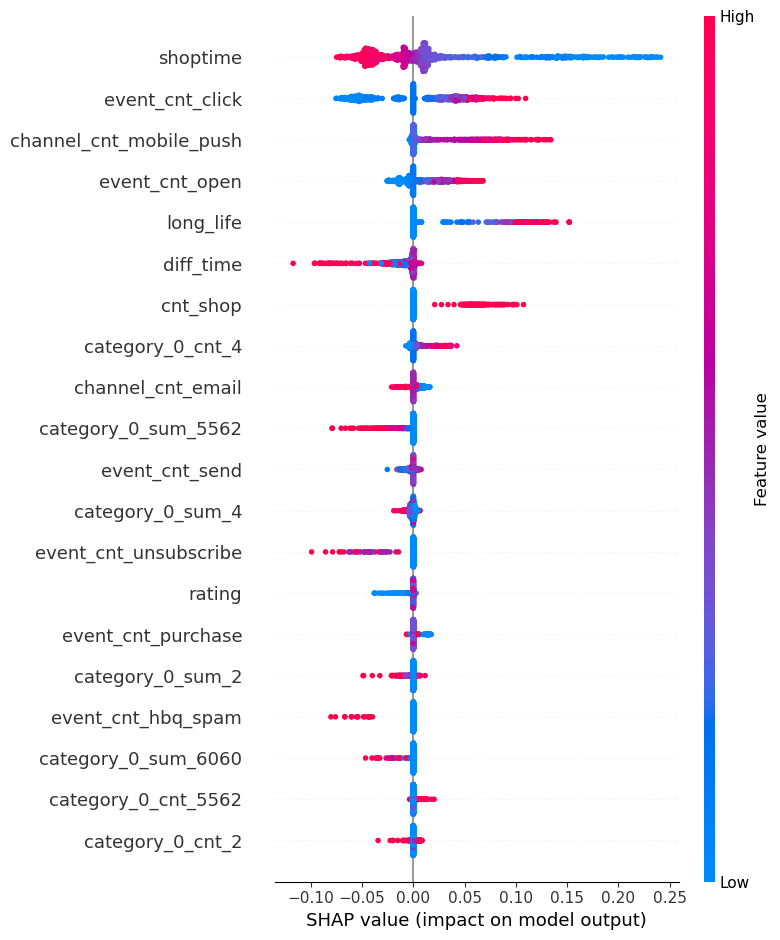

In [159]:
shap.summary_plot(shap_values_norm, X_test_scalled.iloc[0:1000,:], feature_names=X_train_scalled.columns)

In [160]:
shap_values = explainer(X_test_scalled.iloc[0:1000,:])

  0%|          | 0/1000 [00:00<?, ?it/s]

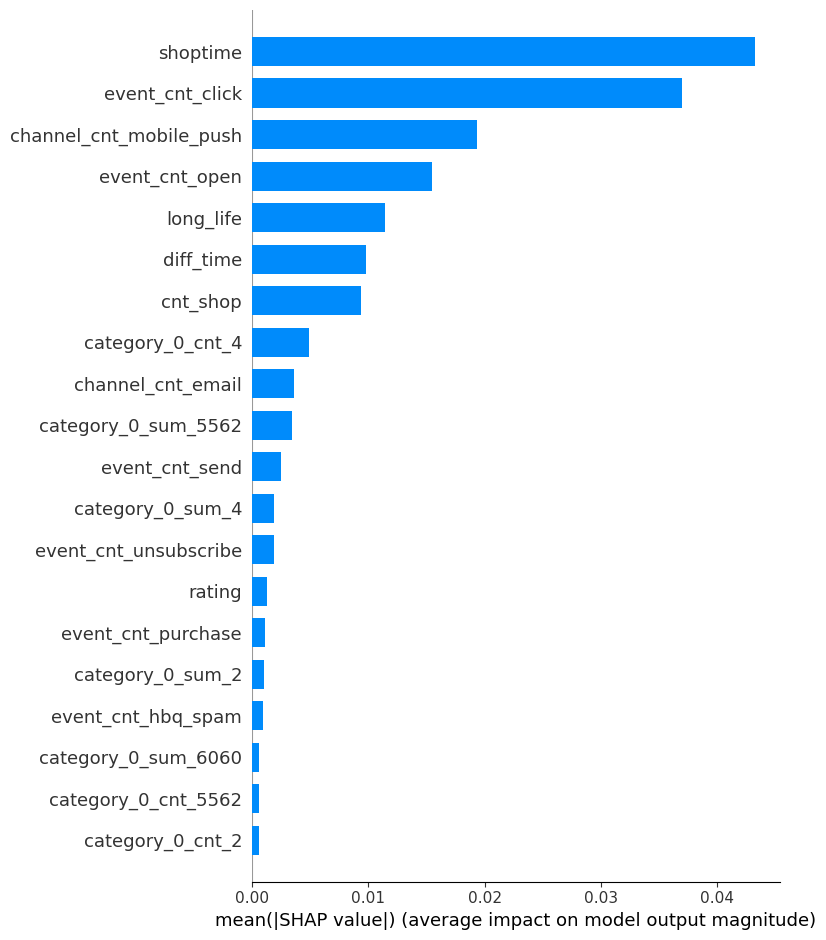

In [161]:
shap.summary_plot(shap_values_norm, X_test_scalled.iloc[0:1000,:], plot_type='bar', \
                  feature_names=X_train_scalled.columns, title = "SHAP Value Summary", max_display=20)

Исходя из анализа признаков лучшими оказались 28шт. Основные выводы исходя из анализа:
- Чем большее число дней прошло с момента последней покупки, тем меньше вероятность новой покупки этим же покупателем.
- Чем больше событий открытия и клика, а также больше пуш уведомлений через мобильный телефон, тем больше вероятность нвоой покупки
- Чем больше разница между временем рассылки сообщений и последней покупкой, тем меньше вероятность новой покупки
- Чем больше покупок покупатель делает, а также чем дольше он покупает через интернет магазин, тем больше вероятность новой покупки.
- Чем больше покупок в категории 4, тем большая вероятность новой покупки.
- Если покупатель откзаывается от подписки, то вероятнее он не будет более делать покупок.

## Общий вывод

<br/>Загружены данные об истории покупателей, истории рекламных рассылок и целевого признака.
<br/>Выполнена предобработка данных: установлены соответствующие типы данных, удалены дубликаты, значение категорий разбито на 4 отдельных столбца
<br/>В результате анализа датасетов были добавлены следующие признаки:
- сумма за покупку в разрезе категории заданного уровня
- количество купленного товара в разрезе категорий
- сумма потраченных клиентом денег в разрезе категорий
- число событий по рекламным сообщениям по каждому клитенту
- число рекламных сообщений в разрезе видов
- число дней между датой последней рассылки и последней покупкой
- число дней от даты выгрузки до последней даты покупки
- продолжительность покупок клиентом 
- число покупок клиентом
- наиболее часто покупаемая категория товара последней покупки. Частота (рейтинг) покупок определена на тренировочной выборке.
<br/>
<br/>В результате корреляционного анализа установлено:
- влияние на целевой признак: число дней от даты выгрузки до последней даты покупки, продолжительность покупок покупателем
- установлена высокая корреляция между признаками: число дней от даты выгрузки до последней даты покупки, продолжительность покупок покупателем
- есть нулевая корреляция между целевым признаком и числом, суммой покупок по отдельными категориям, а также между целевым признаком и отдельными событиями пользователей на рекламные сообщения
<br/><br/>Выполнено обучение трех моделей: деревьев решений, моделей градиентного бустинга LightGBM, CatBoost. Лучшей оказалась CatBoost. Исходя из анализа признаков лучшими оказались 28 признаков. Основные выводы исходя из анализа:
- Чем большее число дней прошло с момента последней покупки, тем меньше вероятность новой покупки этим же покупателем.
- Чем больше событий открытия и клика, а также больше пуш уведомлений через мобильный телефон, тем больше вероятность нвоой покупки
- Чем больше разница между временем рассылки сообщений и последней покупкой, тем меньше вероятность новой покупки
- Чем больше покупок покупатель делает, а также чем дольше он покупает через интернет магазин, тем больше вероятность новой покупки.
- Чем больше покупок в категории 4, тем большая вероятность новой покупки.
- Если покупатель откзаывается от подписки, то вероятнее он не будет более делать покупок.